In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import SimpleRNN, Dense # type: ignore
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD


In [40]:
df_gld = pd.read_csv(r"D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv")
print(df_gld.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [41]:
df_gld['Date'] = pd.to_datetime(df_gld['Date'])

In [42]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df_gld = fill_missing_values_date(df_gld, 'Date', 'GLD')
df_gld.set_index('Date', inplace=True)
data = df_gld['GLD'].values
data = np.reshape(data, (-1,1))

In [43]:
data = df_gld[['GLD']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[0.12967974]
 [0.13587574]
 [0.13203593]
 ...
 [0.47552142]
 [0.46702942]
 [0.45853741]]


In [44]:
split_idx = 3288
data_train, data_test = scaled_data[:split_idx], scaled_data[split_idx:]

In [45]:
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [46]:
time_step = 5
X_train, y_train = create_dataset(data_train, time_step)
X_test, y_test = create_dataset(data_test, time_step)
X_train, y_train = np.array(X_train), np.array(y_train)

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [48]:
model = Sequential()

# adding RNN layers and dropout regularization
model.add(SimpleRNN(units = 50, 
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50, 
                        activation = "tanh",
                        return_sequences = True))

model.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

model.add( SimpleRNN(units = 50))

# adding the output layer
model.add(Dense(units = 1,activation='sigmoid'))

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.compile(optimizer = 'adam', 
                  loss = "mean_squared_error")
batch_size = 64
epochs = 30
model_history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0195
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9645e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0642e-04
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4297e-04
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8857e-04
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8466e-04
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6542e-04
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5423e-04
Epoch 12/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8401e-04
Epoch 13/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7011e-04
Epoch 14/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3992e-04
Epoch 15/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

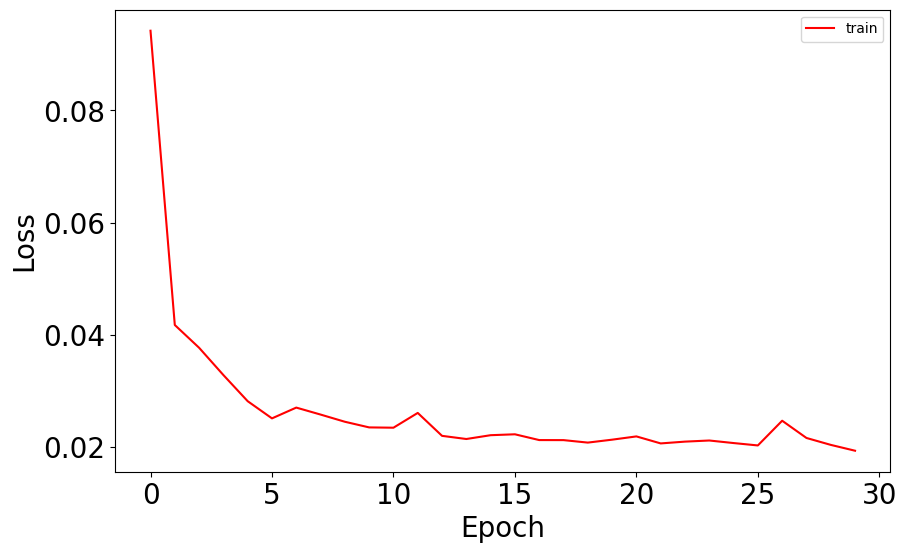

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [51]:
model.fit(X_train, y_train, batch_size = 64, epochs = 30)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4427e-04
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8721e-04
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1716e-04
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4361e-04
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6310e-04
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0183e-04
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5556e-04
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0719e-04
Epoch 9/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2056e-04
Epoch 10/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4536e-04
Epoch 11/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8182e-04
Epoch 12/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9422e-04
Epoch 13/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0545e-04
Epoch 14/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8383e-04
Epoch 15/30
52/52 ━━━━━━━━━━

In [52]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = np.reshape(predicted_prices, -1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [53]:
acctually_prices = data[split_idx+time_step+1:]
acctually_prices = np.reshape(acctually_prices, -1)

In [54]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, predicted_prices)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, predicted_prices)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, predicted_prices)
print(f"MAPE: {mape}")

MSE: 0.8057299988426503
MAE: 0.7008539141310965
MAPE: 0.5768718296879402


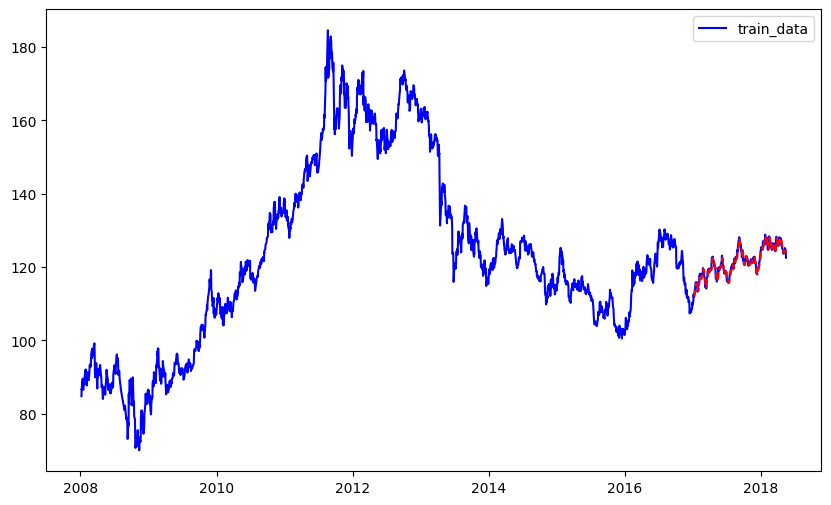

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df_gld.index[time_step:] , data[time_step:],label = "train_data", color = "b")
plt.plot(df_gld.index[time_step+split_idx+1:], predicted_prices, color = "red", linestyle = '--')
plt.legend()
plt.show()